# Problema 2 - Mersenne Twister

Investigar e implementar en Python un generador aleatorio de tipo *Mersenne Twister* para generar una distribución uniforme $Unif(0,1)$.

Igual que en el ejercicio anterior, muestre estadísticos, histogramas y elabore una prueba de hipótesis para contrastar la muestra generada contra la muestra teórica, para determinar el buen funcionamiento del generador pseudo aleatorio. Use como tamaño de muestra un valor adecuado de $N$.

## Librerías

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tabulate import tabulate

## Configurar el generador MT19937

In [3]:
def makeMt(seed=12345678):
    # constructor de rng usando Mersenne Twister (MT19937)
    bitgen = np.random.MT19937(seed)
    return np.random.Generator(bitgen)

## Utilidades (estadísticos, tests, gráficos)

In [4]:
def basicStats(x):
    x = np.asarray(x)
    lag1 = np.corrcoef(x[:-1], x[1:])[0, 1] if x.size > 1 else np.nan
    return {
        "n": x.size,
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)),
        "lag1_autocorr": float(lag1),
    }

In [5]:
def acfLags(x, max_lag=10):
    x = np.asarray(x) - np.mean(x)
    ac = [1.0]
    denom = np.dot(x, x)
    for k in range(1, max_lag + 1):
        ac.append(float(np.dot(x[:-k], x[k:]) / denom))
    return np.array(ac)

In [6]:
def ksTestUniform01(u):
    ks = stats.kstest(u, "uniform", args=(0, 1))
    return {"statistic": float(ks.statistic), "pvalue": float(ks.pvalue)}

In [7]:
def chiSquareBinnedUniform01(u, bins=50):
    # binea [0,1] y contrasta con frecuencias esperadas iguales
    counts, _ = np.histogram(u, bins=bins, range=(0.0, 1.0))
    expected = np.full(bins, len(u) / bins)
    chi2, p = stats.chisquare(counts, f_exp=expected)
    return {"statistic": float(chi2), "pvalue": float(p), "bins": int(bins)}

In [8]:
def plotHistogram(u, bins=50, title="", show=True):
    plt.figure()
    plt.hist(u, bins=bins, range=(0.0, 1.0), density=True, edgecolor="black")
    plt.title(title)
    plt.xlabel("valor")
    plt.ylabel("densidad")
    if show:
        plt.show()

## Ejecutor del experimento

In [9]:
def runMtExperiment(
    N=30000,
    seed=2025,
    bins_hist=40,
    max_lag_acf=10,
    make_plots=True,
    verbose=True,
    return_logs=True,
):
    rng = makeMt(seed=seed)

    # muestra Unif(0,1)
    u = rng.random(N, dtype=np.float64)

    # estadísticos y pruebas
    stats_u = basicStats(u)
    ks = ksTestUniform01(u)
    chi = chiSquareBinnedUniform01(u, bins=bins_hist)
    acf = acfLags(u, max_lag=max_lag_acf)

    if make_plots:
        plotHistogram(u, bins=bins_hist, title=f"MT19937 — Unif(0,1) (N={N}, seed={seed})", show=True)

    table = [
        ["Unif(0,1)", stats_u["mean"], stats_u["std"], stats_u["lag1_autocorr"], ks["statistic"], ks["pvalue"], chi["statistic"], chi["pvalue"]],
    ]

    if verbose:
        print(f"=== MT19937 | N={N} | seed={seed} ===")
        print(tabulate(table, headers=["muestra","media","desv","autocorr_lag1","KS stat","KS pval","Chi2 stat","Chi2 pval"]))
        print("\nacf primeros lags:", np.round(acf[:6], 4))  # lags 0..5

    result = {
        "N": N,
        "seed": seed,
        "sample": u,
        "stats": stats_u,
        "ks_test": ks,
        "chi_square_binned": chi,
        "acf": acf,
        "summary_table": table,
    }

    logs = None
    if return_logs:
        logs = {
            "generator": "MT19937 (Mersenne Twister)",
            "notes": [
                "se usa numpy.random.MT19937 como bit generator",
                "ks contrasta contra Unif(0,1) exacta",
                "chi2 usa bines iguales en [0,1]",
                "con N >= 20k los p-values se estabilizan y el histograma luce plano",
            ]
        }

    return {"result": result, "logs": logs}

## Ejecución

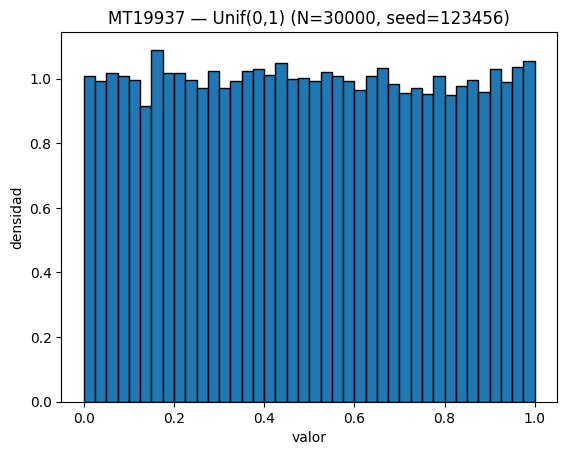

=== MT19937 | N=30000 | seed=123456 ===
muestra       media      desv    autocorr_lag1     KS stat    KS pval    Chi2 stat    Chi2 pval
---------  --------  --------  ---------------  ----------  ---------  -----------  -----------
Unif(0,1)  0.499131  0.289121      -0.00250232  0.00419866   0.663941      30.8747     0.820176

acf primeros lags: [ 1.     -0.0025 -0.0111  0.0025  0.0066  0.0036]


In [10]:
mt_data = runMtExperiment(
    N=30000,
    seed=123456,
    bins_hist=40,
    max_lag_acf=10,
    make_plots=True,
    verbose=True
)

In [11]:
mt_data["logs"], pd.Series(mt_data["result"]["stats"])

({'generator': 'MT19937 (Mersenne Twister)',
  'notes': ['se usa numpy.random.MT19937 como bit generator',
   'ks contrasta contra Unif(0,1) exacta',
   'chi2 usa bines iguales en [0,1]',
   'con N >= 20k los p-values se estabilizan y el histograma luce plano']},
 n                30000.000000
 min                  0.000013
 max                  0.999960
 mean                 0.499131
 std                  0.289121
 lag1_autocorr       -0.002502
 dtype: float64)